In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import sem, t
from scipy import mean

from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm
import pandas as pd
import re
import pickle 

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from trial_config import read_config
from statistics_tests import perform_ks, estimate_power_with_data
from status import Status

In [2]:
config_file = "../config.ini"

In [3]:
config = read_config(config_file)
trial = config["name"]
directory_path = config["score_dir"]
print(f"Trial: {trial} from {directory_path}") 
num_mc_trials = 10

# For loading and saving calculations
test_name = "high_level" 
load_calcs = True

Trial: LLM_Compare_Score from ./data/scoring


In [4]:
# Get all files that end with .parquet
files = [f for f in os.listdir(directory_path) 
         if f.endswith('.parquet') and "Compare_Score" in f]

rows = []
all_df = pd.DataFrame()
for filename in tqdm(files, desc="Processing files"):
    name_without_extension = os.path.splitext(filename)[0]

    file_path = os.path.join(directory_path, filename)
    #print(file_path)
    df = pd.read_parquet(file_path)
    df['Name'] = name_without_extension
    all_df = pd.concat([all_df, df], ignore_index=True)
    
    # Generate Pearson Coefficients
    score_cols = ['Embeddings Distances', 'Resources Distances', 'Scaled Resources', "Score"]
    for x in score_cols:
        #print(x)
        for y in score_cols:
            list_x = df[x].tolist()
            list_y = df[y].tolist()
            corr, p_value = pearsonr(list_x, list_y)
            spearman_corr, spearman_p = spearmanr(list_x, list_y)
            kendall_tau, kendall_p = kendalltau(list_x, list_y)
            # Sample data lists (continuous values)
            mi = mutual_info_regression(np.array(list_x).reshape(-1,1), np.array(list_y))
            mi = mi[0]

            #print(df[x].tolist()[:10])
            #print(f"  - {y}: {corr}, {p_value}")
            rows.append([x, y, corr, p_value, spearman_corr, spearman_p, kendall_tau, kendall_p, mi])

headers = ["Component", "Comparison", "PCC", "PCC (p-value)", "Spearman", "Spearman (p-value)", "Kendall", "Kendall (p-value)", "MI" ]
headers_ks = []
df_pearson = pd.DataFrame(rows, columns=headers)

Processing files:  38%|████████████████████████▋                                        | 19/50 [00:22<00:38,  1.23s/it]/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defin

In [5]:
all_df["Name"].unique()

array(['LLM_Compare_Score___yaml_safe_load',
       'LLM_Compare_Score___ast_literal_eval',
       'LLM_Compare_Score___configparser_ConfigParser_read_string',
       'LLM_Compare_Score___ftplib_FTP',
       'LLM_Compare_Score___rarfile_RarFile',
       'LLM_Compare_Score___xlrd_open_workbook',
       'LLM_Compare_Score___markdown2_markdown',
       'LLM_Compare_Score___bs4_BeautifulSoup',
       'LLM_Compare_Score___pydub_AudioSegment_from_fileformatmp3',
       'LLM_Compare_Score___construct_Struct_parse',
       'LLM_Compare_Score___PIL_Image_open',
       'LLM_Compare_Score___ics_Calendar',
       'LLM_Compare_Score___markdown_markdown',
       'LLM_Compare_Score___email_utils_parseaddr',
       'LLM_Compare_Score___pyexcel_get_sheet',
       'LLM_Compare_Score___smtplib_SMTP',
       'LLM_Compare_Score___toml_loads',
       'LLM_Compare_Score___pandas_read_csv',
       'LLM_Compare_Score___simplejson_loads',
       'LLM_Compare_Score___html_parser_HTMLParser_feed',
       'LLM_Com

In [6]:
df.columns

Index(['Function', 'Corpus', 'Sample', 'Error', 'Output', 'Output Size (B)',
       'Output Entropy (bits per symbol)', 'Function Calls', 'Top Function',
       'Top Function Calls', 'Peak Memory (B)', 'Final Memory (B)', 'CPU (ms)',
       'Repetitions', 'SLOC', 'Instructions', 'Duration (ms)',
       'Output Size (B) Normalized',
       'Output Entropy (bits per symbol) Normalized',
       'Top Function Calls Normalized', 'Peak Memory (B) Normalized',
       'Final Memory (B) Normalized', 'CPU (ms) Normalized', 'SLOC Normalized',
       'Instructions Normalized', 'Sample Text', 'Corpus Location',
       'Embeddings', 'Embeddings Distances', 'Embeddings StdDev',
       'Output Size (B) Quantized',
       'Output Entropy (bits per symbol) Quantized',
       'Top Function Calls Quantized', 'Peak Memory (B) Quantized',
       'Final Memory (B) Quantized', 'CPU (ms) Quantized', 'SLOC Quantized',
       'Instructions Quantized', 'Error Categorical',
       'Top Function Categorical', 'Reso

In [7]:
fields = ["Embeddings Distances", "Scaled Resources", "Resources Distances", "Score" ]

print("Finding LLM Entries")
corpus_comparisons = {}
df = all_df
df.loc[~df['Corpus'].isin(['Random', 'Atheris']), 'Corpus'] = 'LLM'

Finding LLM Entries


In [8]:
print("Splitting Atheris")
atheris_df = df[df['Corpus'] == 'Atheris']
indices_to_change = atheris_df.sample(frac=0.5, random_state=42).index
df.loc[indices_to_change, 'Corpus'] = 'Atheris_2'

print("Splitting Random")
random_df = df[df['Corpus'] == 'Random']
indices_to_change = random_df.sample(frac=0.5, random_state=42).index
df.loc[indices_to_change, 'Corpus'] = 'Random_2'

Splitting Atheris
Splitting Random


In [9]:
df[df['Corpus'] == 'Random_2']

,Function,Corpus,Sample,Error,Output,Output Size (B),Output Entropy (bits per symbol),Function Calls,Top Function,Top Function Calls,...,SLOC Quantized,Instructions Quantized,Error Categorical,Top Function Categorical,Resources,Resources Distances,Resources StdDev,Scaled Resources,Score,Name
10000,TestOneInput,Random_2,4687.txt,unacceptab,,0,0.000000,21,builtins.isinstance},3,...,0,0,5,3,"[5.0, 3.0, 0.0, 0.0, 3.0, 4920.0, 0.0, 0.08100...",1.000000,0.000000,0.000766,0.422755,LLM_Compare_Score___yaml_safe_load
10002,TestOneInput,Random_2,7892.txt,unacceptab,,0,0.000000,21,builtins.isinstance},3,...,0,0,5,3,"[5.0, 3.0, 0.0, 0.0, 3.0, 4733.0, 0.0, 0.07973...",1.000000,0.000000,0.000545,0.460018,LLM_Compare_Score___yaml_safe_load
10006,TestOneInput,Random_2,571.txt,unacceptab,,0,0.000000,21,builtins.isinstance},3,...,0,0,5,3,"[5.0, 3.0, 0.0, 0.0, 3.0, 4832.0, 0.0, 0.07883...",1.000000,0.000000,0.000656,0.477195,LLM_Compare_Score___yaml_safe_load
10007,TestOneInput,Random_2,7804.txt,unacceptab,,0,0.000000,21,builtins.isinstance},3,...,0,0,5,3,"[5.0, 3.0, 0.0, 0.0, 3.0, 4583.0, 0.0, 0.07952...",1.000000,0.000000,0.000371,0.497706,LLM_Compare_Score___yaml_safe_load
10010,TestOneInput,Random_2,100.txt,unacceptab,,0,0.000000,21,builtins.isinstance},3,...,0,0,5,3,"[5.0, 3.0, 0.0, 0.0, 3.0, 4627.0, 0.0, 0.08002...",1.000000,0.000000,0.000424,0.492291,LLM_Compare_Score___yaml_safe_load
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009542,TestOneInput,Random_2,3574.txt,Invalid bo,,0,0.000000,116,objects},24,...,3,3,2,2,"[2.0, 2.0, 0.0, 0.0, 24.0, 4724.0, 59.0, 0.277...",1.000000,0.000000,0.378053,0.583533,LLM_Compare_Score___cgi_parse_multipart_pdict
1009543,TestOneInput,Random_2,2875.txt,'ascii' co,,0,0.000000,23,builtins.ord},10,...,0,0,1,1,"[1.0, 1.0, 0.0, 0.0, 10.0, 4605.0, 59.0, 0.091...",1.000000,0.000000,0.064827,0.507865,LLM_Compare_Score___cgi_parse_multipart_pdict
1009544,TestOneInput,Random_2,2347.txt,Invalid bo,,0,0.000000,116,objects},24,...,3,3,2,2,"[2.0, 2.0, 0.0, 0.0, 24.0, 5031.0, 59.0, 0.285...",1.000000,0.000000,0.384523,0.547433,LLM_Compare_Score___cgi_parse_multipart_pdict
1009545,TestOneInput,Random_2,6618.txt,,{}\n,3,1.584963,143,objects},24,...,4,4,0,2,"[0.0, 2.0, 3.0, 1.584962500721156, 24.0, 4875....",0.984497,0.000004,0.885731,0.727019,LLM_Compare_Score___cgi_parse_multipart_pdict


In [10]:
# models = ['Atheris', 'Random', 'GPT-4', 'GPT-3', 'Claude-Instant', 
#          'Claude-Opus', 'Gemini-1.0']
# test_name = "llms"
test_name = "high_level"
models = ['Atheris', 'Atheris_2', 'Random', 'Random_2', 'LLM']
names_list = all_df["Name"].unique()
ks_headers = ["Component", "Name", "Model", "Comparison", "KS", "p-value", "hypothesis", "power"]
rows_ks = []

# Force nothing to happen if we want to load
if load_calcs: fields = []

for f_count, field in enumerate(fields):
    for m1_count ,c1 in enumerate(models):
        for m2_count, c2 in enumerate(models):
            for n_count, name in enumerate(names_list):
                Status.write(f"{f_count}, {m1_count}, {m2_count}/{len(models)}, {n_count} / {len(names_list)}\n")
                data1 = df[(df['Corpus'] == c1) & (df['Name'] == name)][field]
                data2 = df[(df['Corpus'] == c2) & (df['Name'] == name)][field]
                
                initial_statistic, initial_p_value, hypothesis = perform_ks(data1, data2, config["ks_a"])
                #config["n_simulations"]
                power = estimate_power_with_data(data1, data2, num_mc_trials, config["ks_a"])
                row = [field, name, c1, c2, initial_statistic, initial_p_value, hypothesis, power]
                rows_ks.append(row)
                
df_ks = None
# Make the dataframe and save it
if not load_calcs:
    df_ks = pd.DataFrame(rows_ks, columns = ks_headers)
    df_ks.to_parquet(f"../data/stats/{test_name}_{num_mc_trials}.parquet")
else:
    df_ks = pd.read_parquet(f"../data/stats/{test_name}_{num_mc_trials}.parquet")

/home/g/ruff/statistics_tests.py:18: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  statistic, p_value = ks_2samp(sample1, sample2)
/home/g/ruff/statistics_tests.py:27: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  initial_statistic, initial_p_value = ks_2samp(data1, data2)


In [11]:
df_ks["Model"].unique()

array(['Atheris', 'Atheris_2', 'Random', 'Random_2', 'LLM'], dtype=object)

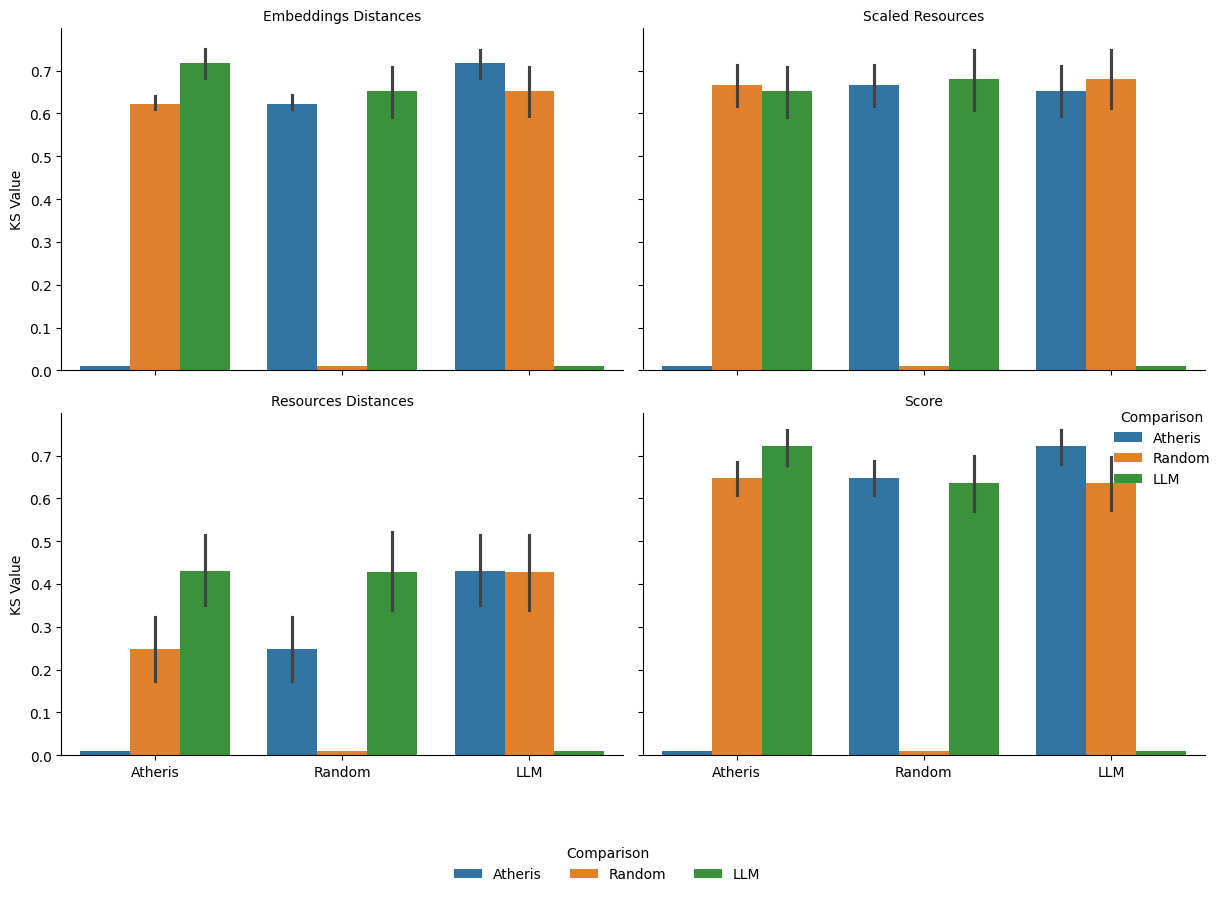

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df_ks[~df_ks['Model'].isin(['Random_2', 'Atheris_2'])]
df_filtered = df_filtered[~df_filtered['Comparison'].isin(['Random_2', 'Atheris_2'])]
df_filtered['KS'] =  df_filtered['KS'].where(df_filtered['KS'] >= 0.01, 0.01)

g = sns.catplot(
    data=df_filtered,#[df_ks['KS'] > 0.05], 
    kind="bar",
    x="Model",
    y="KS",
    hue="Comparison",
    col="Component",
    errorbar=('ci', 95), # Change this to 95 for typical 95% confidence intervals based on the standard error
 #   palette="viridis",
    height=4,
    aspect=1,
    col_wrap=2,
    legend=True
)
g.add_legend(title="Comparison", loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

g.set_titles("{col_name}")  # Set titles for each subplot
g.set_axis_labels("", "KS Value")  # Set x and y labels
plt.tight_layout()
plt.savefig('../images/ks_bargraph.png', bbox_inches='tight')

plt.show()

In [13]:
df_ks["Component"].unique()

array(['Embeddings Distances', 'Scaled Resources', 'Resources Distances',
       'Score'], dtype=object)

# Generate means and CI across tests

Creates a table of comparing sources of data, e.g. Atheris_1 vs. Atheris_2, LLM vs. Random, etc.

In [14]:
df_ks.columns

Index(['Component', 'Name', 'Model', 'Comparison', 'KS', 'p-value',
       'hypothesis', 'power'],
      dtype='object')

In [15]:
test_statistics = ["KS", "p-value", "power"] # KS
# Function to calculate mean and 95% confidence interval
def mean_confidence_interval(data):
    n = len(data)
    m = np.mean(data)
    se = sem(data)  # Standard error
    h = se * t.ppf((1 + 0.95) / 2., n-1)  # Multiplier for 95% CI
    return (m, m-h, m+h)

df_stat_results_header = ["Component", "Statistic", "Model", "Comparison", "Mean", "CI"]

rows = []
for component in df_ks['Component'].unique():
    # Initialize dictionary to store results
    component_results = {}
    for test_statistic in test_statistics:
    # Loop through each unique component to calculate stats
        component_df = df_ks[df_ks['Component'] == component]
        results = component_df.groupby(['Model', 'Comparison'])[test_statistic].apply(mean_confidence_interval).reset_index()
        results[[f'Mean {test_statistic}', 'Lower CI', 'Upper CI']] = pd.DataFrame(results[test_statistic].tolist(), index=results.index)
        result_tuples = [tuple(x) for x in results[['Model', 'Comparison', f'Mean {test_statistic}', 'Upper CI']].to_numpy()]
        for (model, comparison, mean, ci) in result_tuples:
            rows.append([component, test_statistic, model, comparison, mean, ci])

        #overall_results[component] = component_results
        # Printing the results
    #for test_statistic, tuples in component_results.items():
    #    print(f"Component: {component}, Results (Model, Comparison, Mean {test_statistic}, CI):")
    #    for result in tuples:
    #        print(result)
df_stat_results = pd.DataFrame(rows, columns=df_stat_results_header)
df_stat_results = df_stat_results.sort_values(by=['Model', 'Comparison'])

# Clean up names for LaTeX formatting
df_stat_results['Model'] = df_stat_results['Model'].replace('Atheris', 'Atheris$_1$')
df_stat_results['Model'] = df_stat_results['Model'].replace('Random', 'Random$_1$')
df_stat_results['Model'] = df_stat_results['Model'].replace('Random_2', 'Random$_2$')
df_stat_results['Model'] = df_stat_results['Model'].replace('Atheris_2', 'Atheris$_2$')
df_stat_results['Comparison'] = df_stat_results['Comparison'].replace('Atheris', 'Atheris$_1$')
df_stat_results['Comparison'] = df_stat_results['Comparison'].replace('Random', 'Random$_1$')
df_stat_results['Comparison'] = df_stat_results['Comparison'].replace('Random_2', 'Random$_2$')
df_stat_results['Comparison'] = df_stat_results['Comparison'].replace('Atheris_2', 'Atheris$_2$')



In [30]:
def make_power_heatmap(df_power, component):
    df = df_power.copy()

    df['CI'] = df['CI'] - df['Mean']
    df['Mean'] = 1 - df['Mean']
    df['Mean_CI'] = df['Mean'].astype(str) + " ± " + df['CI'].astype(str)

    # Pivot the DataFrame to create matrices of means and annotations
    pivot_df = df.pivot(index="Model", columns="Comparison", values="Mean")
    annot_df = df.pivot(index="Model", columns="Comparison", values="Mean_CI")

    # Format Mean_CI to display as "x.xx ± x.xx"
    def get_power_annot(x):
        mean = float(x.split(' ± ')[0])
        ci = float(x.split(' ± ')[1]) 
        if mean < 0.01: return ""
        return f"{mean:.2f} ± {ci:.2f}"

    annot_df = annot_df.applymap(get_power_annot)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=annot_df, fmt="", cmap="viridis", cbar_kws={'label': rf'Same Distribution Likelihood (H$_0$)'}, linewidths=.5)
    plt.title(fr'{component}: Monte Carlo Testing')
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(f'../images/{component}_power_heatmap.png', bbox_inches='tight')
    plt.show()
    


In [31]:
df_stat_results["Component"].unique()

array(['Embeddings Distances', 'Scaled Resources', 'Resources Distances',
       'Score'], dtype=object)

## Individual Component Testing

Manual process, replace the below **component** variable as needed

In [34]:
component = 'Score' # 'Embeddings Distances', 'Scaled Resources', 'Resources Distances', 'Score'
df_component_eval = df_stat_results[df_stat_results["Component"] == component]


/tmp/ipykernel_195446/3511209196.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_df = annot_df.applymap(get_power_annot)


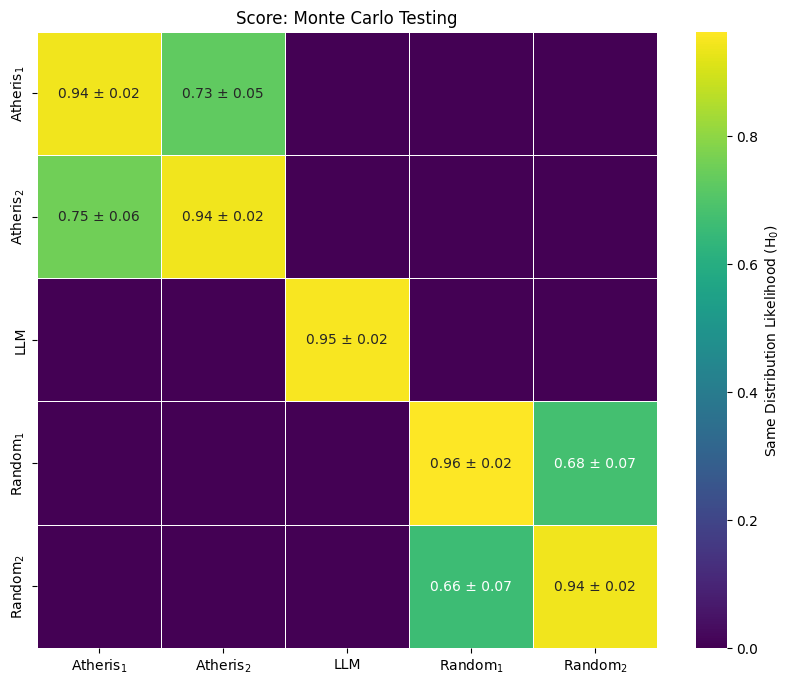

In [35]:
df_power = df_component_eval[df_component_eval["Statistic"] == "power"]
make_power_heatmap(df_power, component)

In [36]:
print(f"##### Rows for {component} Table #####\n")

for m in df_component_eval["Model"].unique():
    print("\midrule")
    print(f"\\textbf{{{m}}} \\\\")
    df_model_eval = df_component_eval[df_component_eval["Model"] == m]
    for stat in ["KS", "p-value", "power"]:
        print(f"\quad {stat}", end="")
        df_stat_eval = df_model_eval[df_model_eval["Statistic"] == stat]
        
        for i, r in df_stat_eval.iterrows():
            mean = r['Mean']
            ci = r['CI'] - mean
            assert ci >= 0, f"{ci} cannot be below 0"
            print(f" & ${mean:0.2f} \pm {ci:0.2f}$", end="")
        print(" \\\\")
    print("")


##### Rows for Score Table #####

\midrule
\textbf{Atheris$_1$} \\
\quad KS & $0.00 \pm 0.00$ & $0.02 \pm 0.00$ & $0.72 \pm 0.04$ & $0.65 \pm 0.04$ & $0.65 \pm 0.04$ \\
\quad p-value & $1.00 \pm 0.00$ & $0.51 \pm 0.09$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ \\
\quad power & $0.06 \pm 0.02$ & $0.27 \pm 0.05$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ \\

\midrule
\textbf{Atheris$_2$} \\
\quad KS & $0.02 \pm 0.00$ & $0.00 \pm 0.00$ & $0.72 \pm 0.04$ & $0.65 \pm 0.04$ & $0.65 \pm 0.04$ \\
\quad p-value & $0.51 \pm 0.09$ & $1.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ \\
\quad power & $0.25 \pm 0.06$ & $0.06 \pm 0.02$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ \\

\midrule
\textbf{LLM} \\
\quad KS & $0.72 \pm 0.04$ & $0.72 \pm 0.04$ & $0.00 \pm 0.00$ & $0.64 \pm 0.06$ & $0.64 \pm 0.06$ \\
\quad p-value & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $1.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ \\
\quad power & $1.00 \pm 0.00$ & $1.0

# Compare Selection Counts

In [37]:
files = [f for f in os.listdir(directory_path) 
         if f.endswith('.pkl')]

In [76]:
counts = { "Function":[], "Type": [], "Atheris": [], "Random": [], "LLM": [] } 
for f in files:
    # Regular expression pattern to capture the required parts
    pattern = r"LLM_Compare_(.+?)___(.+?)\.pkl"

    # Use re.match to apply the pattern
    match = re.match(pattern, f)
    assert match, f"Bad filename {f}"
    trail_name = match.group(1)
    func_name = match.group(2)
    #print("Trail Name:", trail_name)
    #print("Func Name:", func_name)
    with open(f"{directory_path}/{f}", 'rb') as file: d = pickle.load(file)
    tcs = d["Top Counts"]
    
    counts["LLM"].append(tcs["LLM"])
    rnd = 0
    ath = 0
    for k in tcs.keys():
        if k.endswith("random_data"): rnd = tcs[k]
        elif k.endswith("atheris_output"): ath = tcs[k]
    counts["Atheris"].append(ath)
    counts["Random"].append(rnd)
    func_name_short = func_name
    if len(func_name) > 25: func_name_short = func_name[:25] + "..."
    counts["Function"].append(func_name_short)
    counts["Type"].append(trail_name)
#counts

In [78]:
len(counts["Function"])

200

/tmp/ipykernel_195446/2269729239.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Method', y='Count', col='Type', data=data_melted, kind='box',


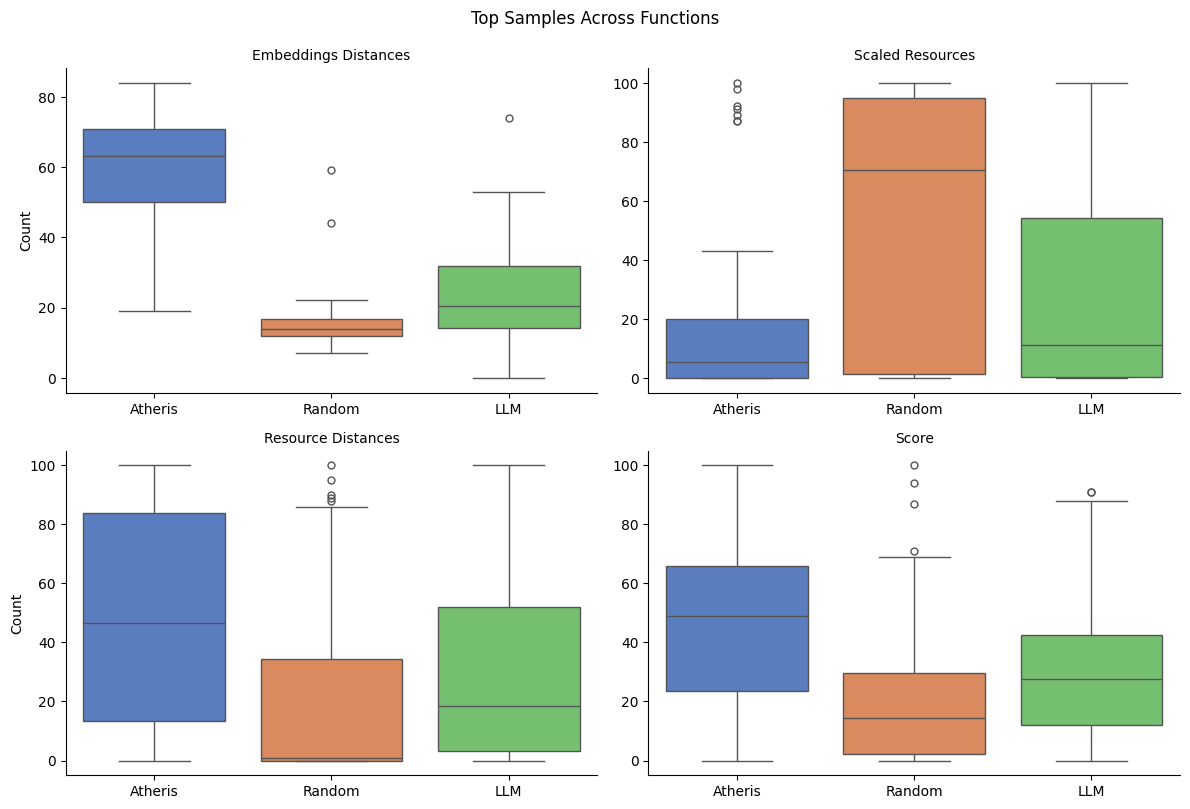

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the lists
data = pd.DataFrame({
    'Atheris': counts["Atheris"],
    'Random': counts["Random"],
    'LLM': counts["LLM"],
    'Type': counts["Type"]

})

type_order = ['Embedding', 'Usage', 'Anomaly', 'Score']
data['Type'] = pd.Categorical(data['Type'], categories=type_order, ordered=True)


replacement_map = {
    'Embedding': 'Embeddings Distances',
    'Usage': 'Scaled Resources',
    'Anomaly': 'Resource Distances'
}

# Replace the values in the 'Type' column
data['Type'] = data['Type'].replace(replacement_map)



# Melt the DataFrame for suitable format for sns.boxplot
data_melted = data.melt(id_vars=['Type'], var_name='Method', value_name='Count')

# Use catplot to create a FacetGrid, one plot for each type
g = sns.catplot(x='Method', y='Count', col='Type', data=data_melted, kind='box',
                col_wrap=2, height=4, aspect=1.5, palette='muted', sharex=False, sharey=False)

g.set_titles("{col_name}") 
g.fig.suptitle('Top Samples Across Functions', y=1.03) 
for ax in g.axes.flat:
    ax.set_xlabel('')  
plt.xlabel('')  
plt.ylabel('')  
plt.savefig('../images/top_samples_box.png', bbox_inches='tight')
plt.show()


#data_melted = data.melt(var_name='Method', value_name='Count')

# Create a boxplot
#sns.boxplot(x='Method', y='Count', data=data_melted)
#plt.title('Comparison of Methods')
#plt.show()

# Create a box plot
#plt.figure(figsize=(8, 6))  # Set the figure size
#data.boxplot()  # Plot box plots for all columns in the DataFrame
#plt.title('Score Distribution of Top-100 Sample Selection')  
#plt.ylabel('Number Selected')  

#plt.grid(False)
#plt.savefig('../images/temp_sample_select.png', bbox_inches='tight')
#plt.show() 

In [112]:
# Create a DataFrame from the lists
data = pd.DataFrame({
    'Function': counts["Function"],
    'Atheris': counts["Atheris"],
    'Random': counts["Random"],
    'LLM': counts["LLM"],
    'Type': counts["Type"]

})
data = data[data['Type'] == 'Score']

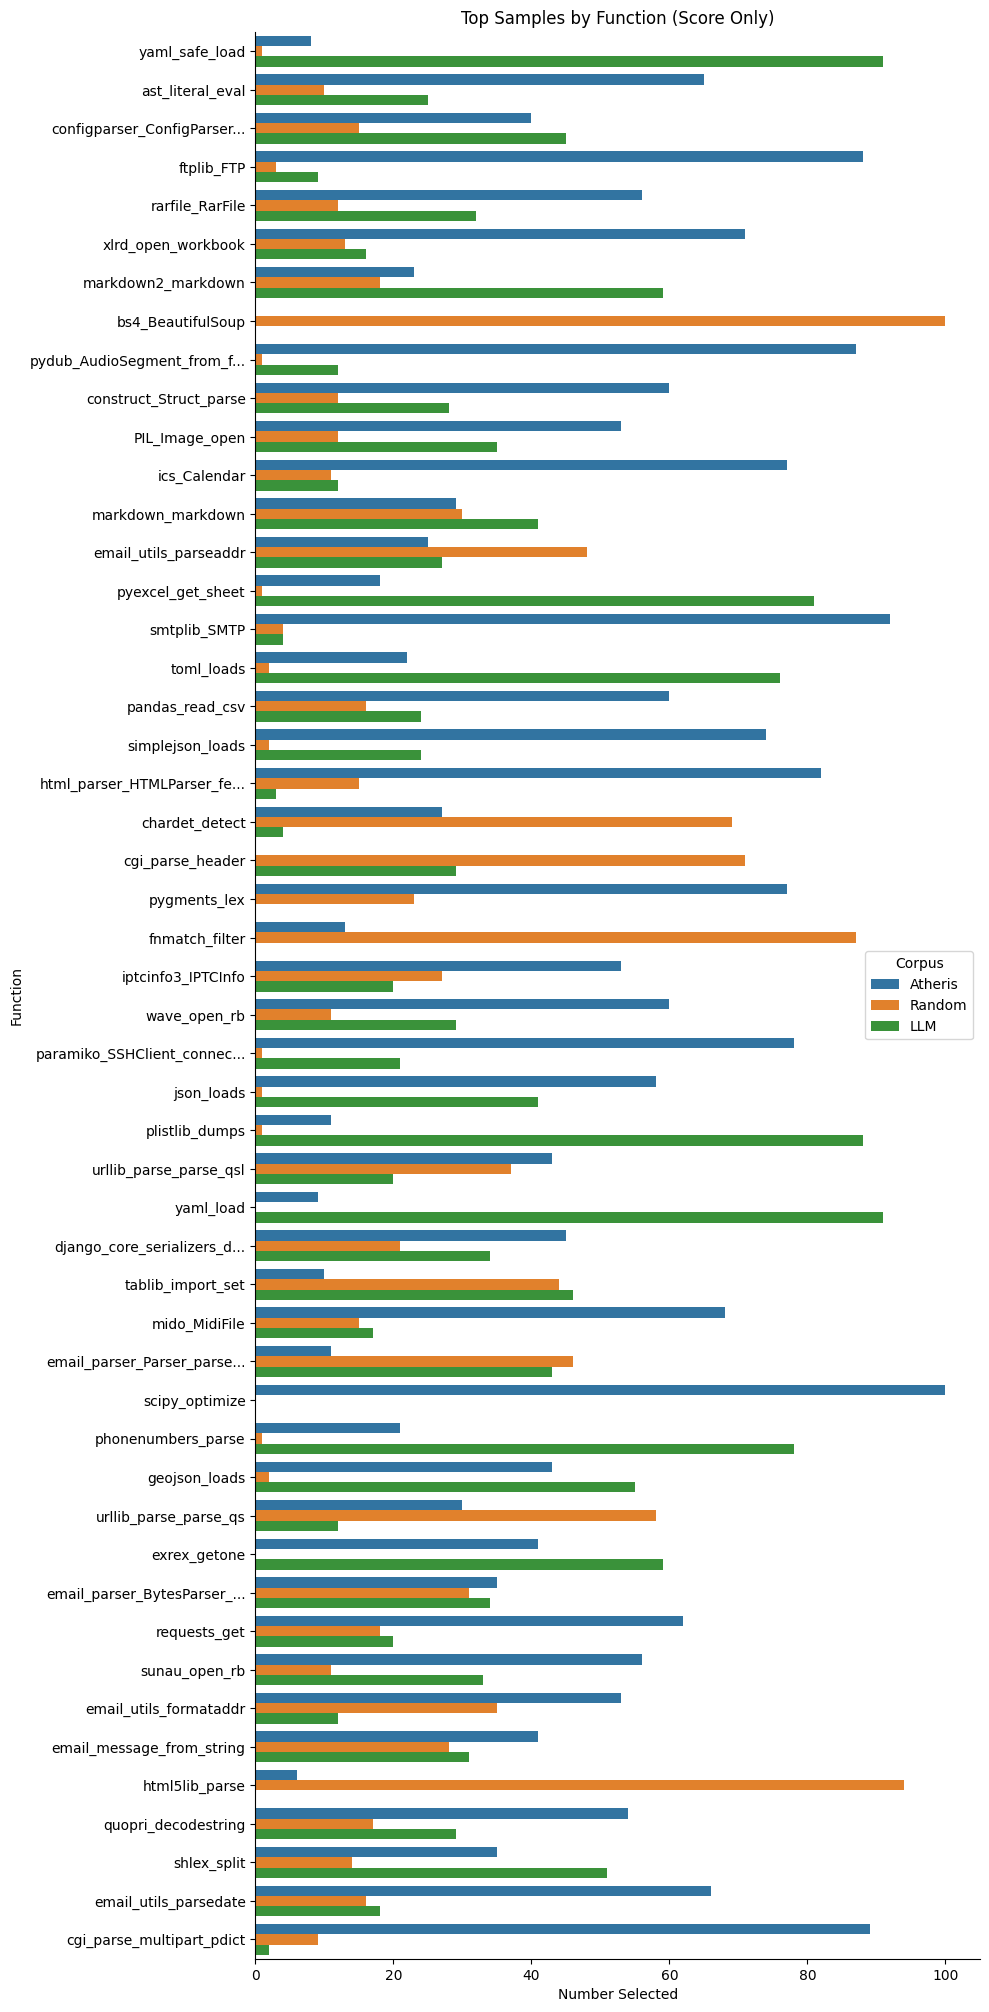

In [113]:
long_data = pd.melt(data, id_vars='Function', value_vars=['Atheris', 'Random', 'LLM'], 
                    var_name='Method', value_name='Value')

# Plotting
g = sns.catplot(
    data=long_data, 
    kind='bar', 
    x='Value', 
    y='Function', 
    hue='Method',
    errorbar=('ci', 95),
    height=20, 
    aspect=0.5,
    legend_out=False
)

# Improve layout
plt.title('Top Samples by Function (Score Only)')
plt.xlabel('Number Selected')
plt.legend(title='Corpus')

plt.savefig('../images/score_samples_functions.png', bbox_inches='tight')
plt.show()

# Compare score component relations

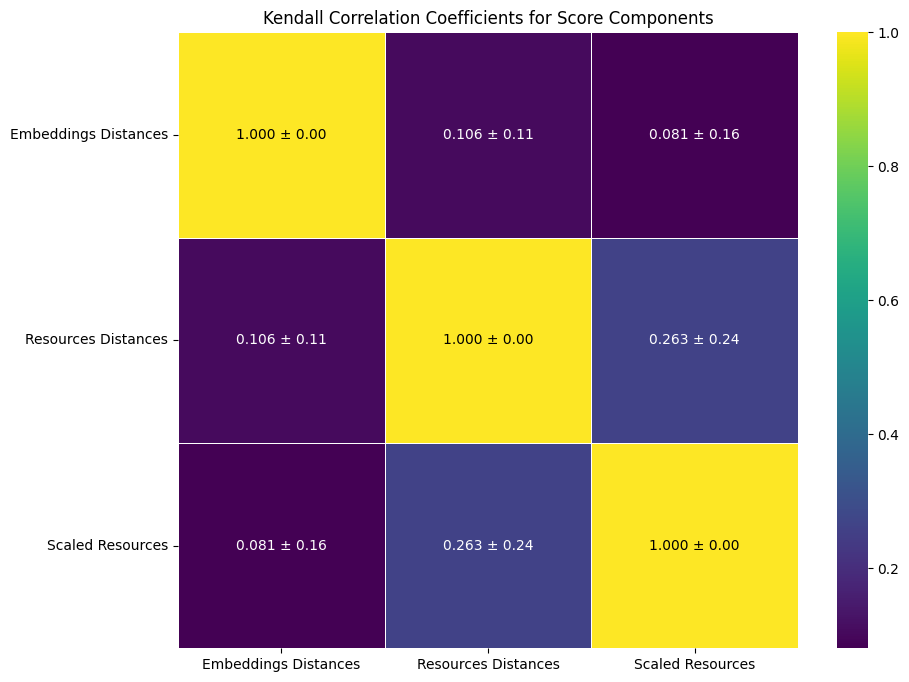

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = df_pearson
corr_field = "Kendall"
df = df[~((df['Component'] == 'Score') | (df['Comparison'] == 'Score'))]

# Aggregate data to compute mean correlation and standard deviation as CI half-width
aggregated_data = df.groupby(['Component', 'Comparison']).agg(
    Mean_Correlation=(corr_field, 'mean'),
    CI_Half_Width=(corr_field, 'std')
).reset_index()

# Fill NaNs in CI_Half_Width with 0 where there's no variance
aggregated_data['CI_Half_Width'].fillna(0, inplace=True)

# Pivot the DataFrame for the heatmap
aggregated_data["Mean_Correlation"] = aggregated_data["Mean_Correlation"].abs()
correlation_matrix = aggregated_data.pivot(index='Component', columns='Comparison', values='Mean_Correlation')
ci_matrix = aggregated_data.pivot(index='Component', columns='Comparison', values='CI_Half_Width')

# Create heatmap with a more readable color scheme
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='viridis', linewidths=.5)

# Adjust tick position and layout
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_ylim(len(correlation_matrix), 0)  # Adjust the y-axis limits

# Adding CI annotations manually to ensure alignment and dynamic text color
for (i, j), val in np.ndenumerate(correlation_matrix):
    if not np.isnan(val):  # Only annotate non-NaN values
        text_color = 'white' if val < 0.5 else 'black'  # Change text color based on value for better visibility
        ci_text = f"{val:.3f} ± {ci_matrix.iloc[i, j]:.2f}"
        plt.text(j+0.5, i+0.5, ci_text, ha='center', va='center', color=text_color)

plt.title(f'{corr_field} Correlation Coefficients for Score Components')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'../images/{corr_field}_heatmap.png', bbox_inches='tight')
plt.show()
